# Feature Selection

The number of columns in the processed data set was 53, which made the models less interpretable. So we implemented the following three techniques using `sklearn` for feature selection:
- Select From Model
- Recursive Feature Elimination with cross-validation (RFECV)
- Recursive Feature Elimination (RFE) 

In this notebook, we have explored all the three approaches. However, we have finally used the features selected using RFE method because:
- SelectFromModel() removed just one feature and returned 52 selected features
- RFECV() was inconsistent and the selected features varied depending upon the number of observations used
- RFE() was consistent and gave the same 8 features under multiple scenarios.

**Conclusions from this notebook:**

We observed that the same recall score could be achieved using only eight (8) features. This resulted in dimensionality reduction without impacting the model performance. The final selected features were used subsequently for model training and risk classification.

## Imports

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
)
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in train dataset

In [2]:
api_df = pd.read_excel("../../data/processed/preprocessed_train.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [6]:
# Balanced training data
X_train, y_train = create_smote(X_train, y_train, 2)

## Baseline Performance

In [7]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [8]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [9]:
# Logistic Regression model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["lr"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [10]:
# Decision Tree model
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
results["dt"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [11]:
pd.DataFrame(results)

,lr,dt
fit_time,0.052 (+/- 0.023),0.011 (+/- 0.002)
score_time,0.010 (+/- 0.003),0.009 (+/- 0.003)
test_accuracy,0.995 (+/- 0.004),0.998 (+/- 0.002)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.004),0.998 (+/- 0.002)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.004),0.998 (+/- 0.002)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000)


## Feature Importance

In [12]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [13]:
data_coef = {
    "coefficient": pipe_lr.named_steps['logisticregression'].coef_.tolist()[0],
    "magnitude": np.absolute(pipe_lr.named_steps['logisticregression'].coef_)[0],
}
coef_df = pd.DataFrame(data_coef, index=X_train.columns).sort_values("magnitude", ascending=False)
coef_df

,coefficient,magnitude
is_fii,2.398142,2.398142
Information & Science,-0.952269,0.952269
is_pii,0.936569,0.936569
x0_Missing,-0.895707,0.895707
server,-0.855642,0.855642
metadata_fields_count,-0.807551,0.807551
parameters_count,-0.658364,0.658364
security_test_result_processed,0.622859,0.622859
Government & Public Services,-0.600504,0.600504
x0_Broken Authentication,0.590945,0.590945


## Feature Selection

### Feature Selection using SelectFromModel

In [14]:
select_lr = SelectFromModel(LogisticRegression(), threshold="mean")

In [15]:
pipe_dt_model_based = make_pipeline(
    StandardScaler(), select_lr, DecisionTreeClassifier(random_state=42)
)
results["dt+model_based_fs"] = mean_std_cross_val_scores(
    pipe_dt_model_based, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [16]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs
fit_time,0.052 (+/- 0.023),0.011 (+/- 0.002),0.052 (+/- 0.024)
score_time,0.010 (+/- 0.003),0.009 (+/- 0.003),0.008 (+/- 0.002)
test_accuracy,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [17]:
pipe_dt_model_based.fit(X_train, y_train)
pipe_dt_model_based.named_steps["selectfrommodel"].n_features_in_

52

### Feature Selection using RFECV

In [18]:
rfecv = RFECV(LogisticRegression())
pipe_dt_rfecv = make_pipeline(
    StandardScaler(), rfecv, DecisionTreeClassifier(random_state=42)
)
results["dt+rfecv"] = mean_std_cross_val_scores(
    pipe_dt_rfecv, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [19]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs,dt+rfecv
fit_time,0.052 (+/- 0.023),0.011 (+/- 0.002),0.052 (+/- 0.024),9.581 (+/- 2.694)
score_time,0.010 (+/- 0.003),0.009 (+/- 0.003),0.008 (+/- 0.002),0.008 (+/- 0.002)
test_accuracy,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002),0.999 (+/- 0.001)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002),0.999 (+/- 0.001)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002),0.999 (+/- 0.001)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [20]:
pipe_dt_rfecv.fit(X_train, y_train)
pipe_dt_rfecv.named_steps["rfecv"].n_features_

7

In [21]:
rfecv_fs = pipe_dt_rfecv.named_steps["rfecv"].support_
rfecv_selected_feats = X_train.columns[rfecv_fs]
rfecv_selected_feats

Index(['is_pii', 'is_fii', 'authentication_processed',
       'x0_Broken Authentication', 'x0_Missing', 'server',
       'metadata_fields_count'],
      dtype='object')

### Feature Selection using RFE

In [22]:
select_rfe = RFE(LogisticRegression(), n_features_to_select=8)
pipe_dt_rfe = make_pipeline(StandardScaler(), select_rfe, DecisionTreeClassifier(random_state=42))
results["dt+rfe"] = mean_std_cross_val_scores(
    pipe_dt_rfe, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [23]:
pd.DataFrame(results)

,lr,dt,dt+model_based_fs,dt+rfecv,dt+rfe
fit_time,0.052 (+/- 0.023),0.011 (+/- 0.002),0.052 (+/- 0.024),9.581 (+/- 2.694),1.513 (+/- 0.081)
score_time,0.010 (+/- 0.003),0.009 (+/- 0.003),0.008 (+/- 0.002),0.008 (+/- 0.002),0.008 (+/- 0.001)
test_accuracy,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002),0.999 (+/- 0.001),0.999 (+/- 0.002)
train_accuracy,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1_macro,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002),0.999 (+/- 0.001),0.999 (+/- 0.002)
train_f1_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall_macro,0.995 (+/- 0.004),0.998 (+/- 0.002),0.998 (+/- 0.002),0.999 (+/- 0.001),0.999 (+/- 0.002)
train_recall_macro,0.999 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


In [24]:
pipe_dt_rfe.fit(X_train, y_train)
pipe_dt_rfe.named_steps["rfe"].n_features_

8

In [25]:
rfe_fs = pipe_dt_rfe.named_steps["rfe"].support_
rfe_selected_feats = X_train.columns[rfe_fs]
rfe_selected_feats

Index(['is_pii', 'is_fii', 'authentication_processed', 'Information & Science',
       'x0_Broken Authentication', 'x0_Missing', 'server',
       'metadata_fields_count'],
      dtype='object')

## Plot for model performace vs. number of features

In [26]:
n_feats = np.arange(1, 53)
train_scores = []
cv_scores = []

for n in n_feats:
    rfe = RFE(LogisticRegression(), n_features_to_select=n)
    pipe = make_pipeline(StandardScaler(), rfe, DecisionTreeClassifier())
    scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(scores["train_score"].mean())
    cv_scores.append(scores["test_score"].mean())

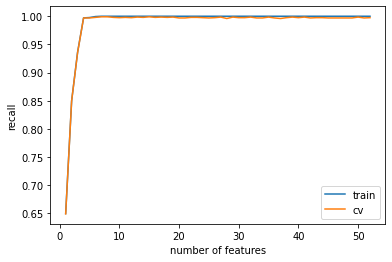

In [27]:
plt.plot(n_feats, train_scores, label="train")
plt.plot(n_feats, cv_scores, label="cv")
plt.legend()
plt.xlabel("number of features")
plt.ylabel("recall");